# Введение в искусственные нейронные сети
# Урок 6. Сегментация
## Практическое задание   


Вариант 1
<ol>
<li>Попробуйте обучить нейронную сеть U-Net на любом другом датасете.  
<li>Опишите, какой результата вы получили? Что помогло вам улучшить качество сети?  
</ol>


### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML('<style>.container { width:72.5% !important; }</style>'))

In [2]:
import numpy as np
import pandas as pd

import os
import random
import cv2

from PIL import Image
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Tensorflow with GPU

In [5]:
%tensorflow_version 2.x
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

def cpu():
    with tf.device('/cpu:0'):
        random_image_cpu = tf.random.normal((100, 100, 100, 3))
        net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
        return tf.math.reduce_sum(net_cpu)

def gpu():
    with tf.device('/device:GPU:0'):
        random_image_gpu = tf.random.normal((100, 100, 100, 3))
        net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
        return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup='from __main__ import cpu')
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup='from __main__ import gpu')
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.812944425999973
GPU (s):
0.03485430999995742
GPU speedup over CPU: 80x


## Panoptic Segmentation

https://www.cityscapes-dataset.com/panoptic-segmentation/

### Загрузка данных

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
def LoadImage(name, path='/content/drive/MyDrive/Colab Notebooks/my_projects/cityscapes_data/train',
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 200)):
    img = Image.open(path+'/'+name)
    img = np.array(img)
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]
    
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)
    
    

    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]

        #seg = np.round(seg/255.0)
    
    return img/255, seg/255

In [12]:
files=os.listdir('/content/drive/MyDrive/Colab Notebooks/my_projects/cityscapes_data/train')[0:10]

colors = []
for file in files:
    img, seg = LoadImage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(13)
km.fit(colors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [13]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

### Построение модели

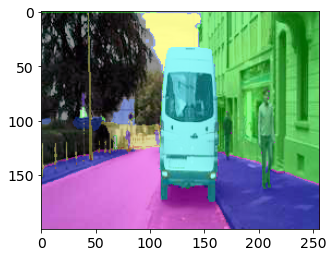

In [14]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

img, seg = LoadImage('174.jpg')
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
plt.imshow(total[:,:,:])
plt.show()

### Data Generator

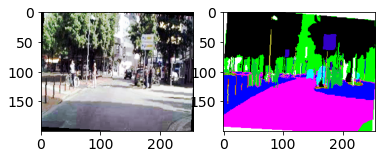

In [15]:
def Generate(path='/content/drive/MyDrive/Colab Notebooks/my_projects/cityscapes_data/train', batch_size=10,
            maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,1)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = LoadImage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)
        
gen = Generate()
imgs, segs = next(gen)

plt.subplot(121)
plt.imshow(imgs[0])
plt.subplot(122)
plt.imshow(LayersToRGBImage(segs[0]))
plt.show()

### Model / The Convolutional Neural Network - UNet

In [16]:
inp = Input(shape=(200, 256, 3))

x1 = BatchNormalization()(inp)
x1 = Conv2D(64, 12, activation='relu', padding='same')(x1)
x1 = Conv2D(128, 12, activation='relu', padding='same')(x1)
p1 = MaxPooling2D()(x1)
#p1 = Dropout(0.2)(p1)

#x2 = BatchNormalization()(x1)
x2 = Conv2D(128, 9, activation='relu', padding='same')(p1)
x2 = Conv2D(128, 9, activation='relu', padding='same')(x2)
p2 = MaxPooling2D()(x2)
#p2 = Dropout(0.2)(p2)

#x3 = BatchNormalization()(x2)
x3 = Conv2D(128, 6, activation='relu', padding='same')(p2)
x3 = Conv2D(128, 6, activation='relu', padding='same')(x3)
p3 = MaxPooling2D()(x3)
#p3 = Dropout(0.2)(p3)

#x4 = BatchNormalization()(x3)
x4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
x4 = Conv2D(128, 3, activation='relu', padding='same')(x4)
#x4 = MaxPooling2D()(x4)
#x4 = Dropout(0.2)(x4)

x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation='relu', padding='same')(x5)
x5 = Conv2D(128, 6, activation='relu', padding='same')(x5)
#x5 = Dropout(0.2)(x5)

x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 6, activation='relu', padding='same')(x6)
x6 = Conv2D(128, 6, activation='relu', padding='same')(x6)
#x6 = Dropout(0.2)(x6)

x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(13, 6, activation='relu', padding='same')(x7)
x7 = Conv2D(13, 6, activation='softmax', padding='same')(x7)



model = Model(inp, x7)

opt = Adam(lr=0.0001)
model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 200, 256, 64) 27712       batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 200, 256, 128 1179776     conv2d_22[0][0]                  
______________________________________________________________________________________________

In [17]:
train_gen = Generate()
val_gen = Generate('/content/drive/MyDrive/Colab Notebooks/my_projects/cityscapes_data/val')

In [18]:
%%time

clb = [ModelCheckpoint('loss.h5', save_best_only=True, verbose=0)]

h = model.fit_generator(train_gen, epochs=1000, steps_per_epoch=10,
                       validation_data=val_gen, validation_steps=10,
                       callbacks=clb, verbose=0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


CPU times: user 3h 13min 38s, sys: 2h 33min 17s, total: 5h 46min 55s
Wall time: 4h 17min 36s


In [19]:
model.save('model.h5')
model = load_model('loss.h5')

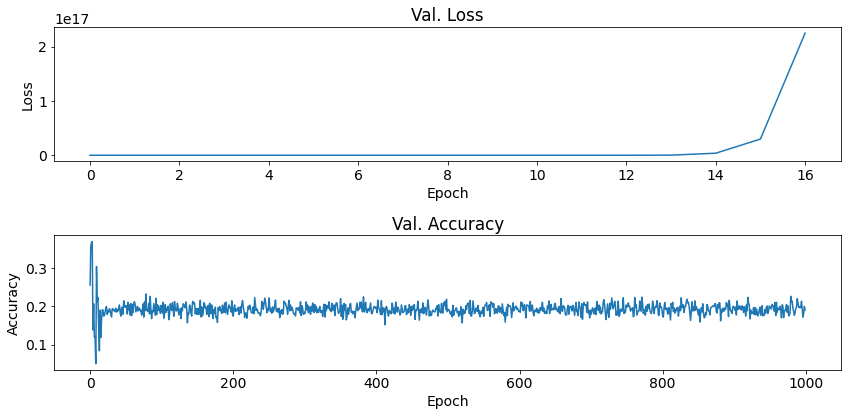

In [24]:
loss = h.history['val_loss']
acc = h.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title('Val. Loss')
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(212)
plt.title('Val. Accuracy')
plt.plot(acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.savefig('learn.png', dpi=150)
plt.show()

### Results

In [26]:
test_gen = Generate('/content/drive/MyDrive/Colab Notebooks/my_projects/cityscapes_data/val')
max_show=20
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.title('Prediction')
        plt.imshow(predimg)
        plt.axis('off')
        plt.subplot(122)
        plt.title('True')
        plt.imshow(trueimg)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('pred_'+str(i)+'.png', dpi=150)
        plt.show()
    break

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


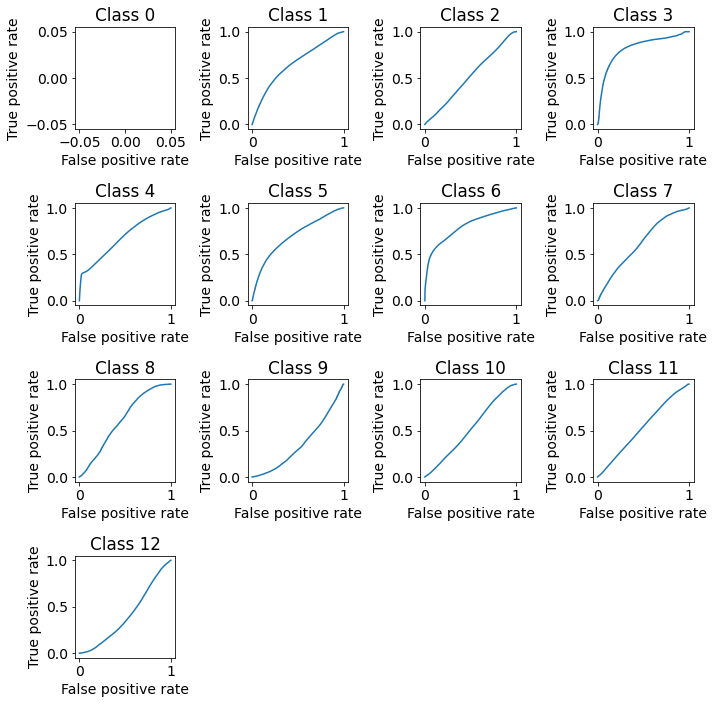

In [27]:
from sklearn.metrics import roc_curve, balanced_accuracy_score
test_gen = Generate('/content/drive/MyDrive/Colab Notebooks/my_projects/cityscapes_data/val', batch_size=200)
max_show=20

bass = []

for imgs, segs in test_gen:
    p = model.predict(imgs)
    
    plt.figure(figsize=(10, 10))
    for i in range(p.shape[-1]):
        fpr, tpr, _ = roc_curve(segs[:,:,:,i].ravel(), p[:,:,:,i].ravel())
        
        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        bas = balanced_accuracy_score(segs[:,:,:,i].ravel(), _p)
        
        bass.append(bas)
        
        plt.subplot(4,4,i+1)
        plt.plot(fpr, tpr)
        plt.title('Class '+str(i))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
    
    plt.tight_layout()
    plt.show()
    
    break

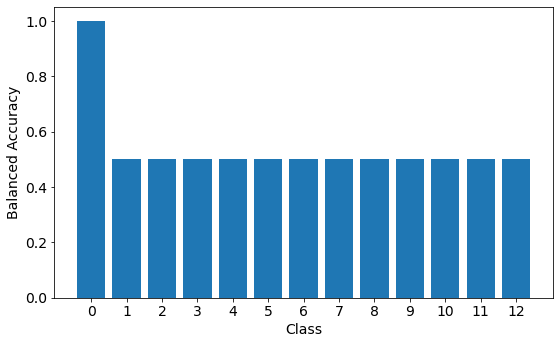

In [29]:
plt.figure(figsize=(8, 5))
plt.bar(np.arange(0, len(bass)), bass)
plt.xticks(np.arange(0, len(bass)))
plt.ylabel('Balanced Accuracy')
plt.xlabel('Class')
plt.tight_layout()
plt.savefig('bas.png')
plt.show()